# Speeding up Numpy and Pandas using `numexpr` and `pd.eval`
## Dr. Tirthajyoti Sarkar, Fremont, CA

In [1]:
import numpy as np
import numexpr as ne
import pandas as pd
import matplotlib.pyplot as plt

## A simple vector-scalar addition

In [2]:
a = np.arange(1e6)
b = np.arange(1e6)

In [3]:
%%timeit -n200 -r10
c = a+1

3.55 ms ± 52.1 µs per loop (mean ± std. dev. of 10 runs, 200 loops each)


In [4]:
%%timeit -n200 -r10
c = ne.evaluate("a + 1")

1.94 ms ± 86.5 µs per loop (mean ± std. dev. of 10 runs, 200 loops each)


## Arithmatic operation involving two arrays

In [5]:
%%timeit -n100 -r10
c = 2*a+3*b

11.7 ms ± 177 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [6]:
%%timeit -n100 -r10
c = ne.evaluate("2*a+3*b")

2.14 ms ± 130 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


## More complicated operation involving more arrays

Evaluate,

$$c = \frac{a_1^2+2a_2+(3/a_3)}{\sqrt{a_4^2+a_5^2}}$$

In [56]:
a = np.random.normal(size=(1000000,5))
a1,a2,a3,a4,a5 = a[:,0],a[:,1],a[:,2],a[:,3],a[:,4]

In [59]:
%%timeit -n100 -r10
c = (a1**2+2*a2+(3/a3))/(np.sqrt(a4**2+a5**2))

47 ms ± 220 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [60]:
%%timeit -n100 -r10
ne.evaluate("(a1**2+2*a2+(3/a3))/(sqrt(a4**2+a5**2))")

3.96 ms ± 218 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


## Expression involving a conditional (boolean filtering)

In [61]:
x1 = np.random.random(1000000)
x2 = np.random.random(1000000)
y1 = np.random.random(1000000)
y2 = np.random.random(1000000)

In [62]:
%%timeit -n100 -r10
c = np.sqrt((x1-x2)**2+(y1-y2)**2) > 0.5

23.2 ms ± 143 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [63]:
%%timeit -n100 -r10
c = ne.evaluate("sqrt((x1-x2)**2+(y1-y2)**2) > 0.5")

1.86 ms ± 112 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [10]:
%%timeit -n100 -r10
c = ne.evaluate("2*a+3*b > 3.5",optimization='moderate')

763 µs ± 85.4 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


## Expression involving complex numbers

In [64]:
a = np.random.random(1000000)
b = np.random.random(1000000)

In [65]:
cplx = a + b*1j

In [66]:
%%timeit -n100 -r10
c = np.log10(cplx)

55.9 ms ± 159 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [67]:
%%timeit -n100 -r10
c = ne.evaluate("log10(cplx)")

9.9 ms ± 117 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


## How the array size impacts the speed improvement

In [15]:
from time import time

In [16]:
result_np = {'Size':[],'Time':[]}
for i in [int(10**(j/5)) for j in range(25,40)]:
    a = np.random.random(size=i)
    b = np.random.random(size=i)
    times = [0]*10
    for j in range(10):
        t1 = time()
        c = (2*a+3*b > 3.5)
        t2 = time()
        times[j]=(t2-t1)*1000
    times = np.array(times)
    result_np['Size'].append(i)
    result_np['Time'].append(times.mean())

In [17]:
result_ne = {'Size':[],'Time':[]}
for i in [int(10**(j/5)) for j in range(25,40)]:
    a = np.random.random(size=i)
    b = np.random.random(size=i)
    times = [0]*10
    for j in range(10):
        t1 = time()
        c = ne.evaluate("2*a+3*b > 3.5")
        t2 = time()
        times[j]=(t2-t1)*1000
    times = np.array(times)
    result_ne['Size'].append(i)
    result_ne['Time'].append(times.mean()) 

In [26]:
def speed_benchmark(result1,result2,leg_text):
    """
    Plots timing results
    """
    plt.semilogx(result1['Size'],result1['Time'],c='blue',marker='o')
    plt.semilogx(result2['Size'],result2['Time'],c='k',marker='^')
    plt.grid(True)
    plt.legend(leg_text,fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Number of elements in the array',fontsize=15)
    plt.ylabel("Time (milliseconds)",fontsize=15)
    plt.show()

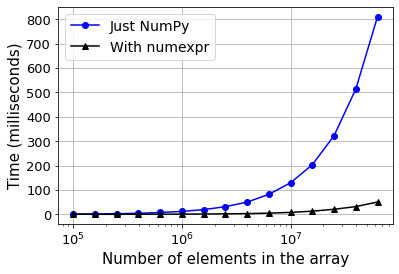

In [27]:
speed_benchmark(result_np,result_ne,leg_text=['Just NumPy','With numexpr'])

## Pandas `pd.eval`

In [46]:
nrows, ncols = 50000, 100

In [47]:
df1, df2, df3, df4 = [pd.DataFrame(np.random.randn(nrows, ncols)) for _ in range(4)]

In [50]:
%%timeit -n20 -r10
c=2*df1 - (df2/2) + (df3/df4)

55.8 ms ± 1.8 ms per loop (mean ± std. dev. of 10 runs, 20 loops each)


In [51]:
%%timeit -n20 -r10
pd.eval('2*df1 - (df2/2) + (df3/df4)')

17.3 ms ± 539 µs per loop (mean ± std. dev. of 10 runs, 20 loops each)


## How the DataFrame size impacts the speed

In [43]:
ncols=100
result_no_eval = {'Size':[],'Time':[]}
for i in [int(10**(j/5)) for j in range(15,32)]:
    df1, df2, df3, df4 = [pd.DataFrame(np.random.randn(i, ncols)) for _ in range(4)]
    times = [0]*10
    for j in range(10):
        t1 = time()
        c = df1+df2+df3+df4
        t2 = time()
        times[j]=(t2-t1)*1000
    times = np.array(times)
    result_no_eval['Size'].append(i)
    result_no_eval['Time'].append(times.mean())

In [44]:
ncols=100
result_eval = {'Size':[],'Time':[]}
for i in [int(10**(j/5)) for j in range(15,32)]:
    df1, df2, df3, df4 = [pd.DataFrame(np.random.randn(i, ncols)) for _ in range(4)]
    times = [0]*10
    for j in range(10):
        t1 = time()
        c = ne.evaluate("df1+df2+df3+df4")
        t2 = time()
        times[j]=(t2-t1)*1000
    times = np.array(times)
    result_eval['Size'].append(i)
    result_eval['Time'].append(times.mean())

In [38]:
def speed_benchmark_pd(result1,result2,leg_text):
    """
    Plots timing results
    """
    plt.semilogx(result1['Size'],result1['Time'],c='blue',marker='o')
    plt.semilogx(result2['Size'],result2['Time'],c='k',marker='^')
    plt.grid(True)
    plt.legend(leg_text,fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Number of rows in the DataFrame',fontsize=15)
    plt.ylabel("Time (milliseconds)",fontsize=15)
    plt.show()

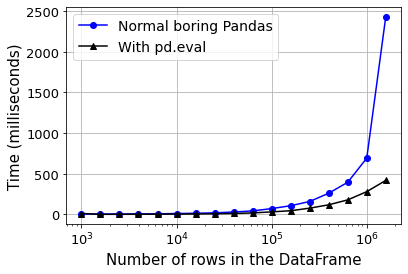

In [45]:
speed_benchmark_pd(result_no_eval,result_eval,
                   leg_text=['Normal boring Pandas','With pd.eval'])